# Data filtering

In [122]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from numpy.linalg import inv
plt.rcParams['figure.figsize'] = [15, 6]
np.random.seed(42)

## Sample generation

In [123]:
# Some constants and the time axis
slow_sample_size = 100
full_sample_size = 1000 * slow_sample_size
st = np.linspace(0, 10, num=slow_sample_size, endpoint=True)
t = np.linspace(0, 10, num=full_sample_size, endpoint=True)

In [124]:
zoom_plot_size = 10000

In [125]:
# Generating the "slow" sample and interpolating to the full sample size
slow_sample =  50 * np.random.rand(slow_sample_size)
interpolator = interp1d(st, slow_sample, kind='cubic')
slow_component = interpolator(t)

In [147]:
# Generating the "fast" sample
# amplitude is smaller than the slow component 
fast_component = np.random.normal(0, 6, full_sample_size)
#print(np.var(fast_component))
signal = slow_component + fast_component

35.91445494313872


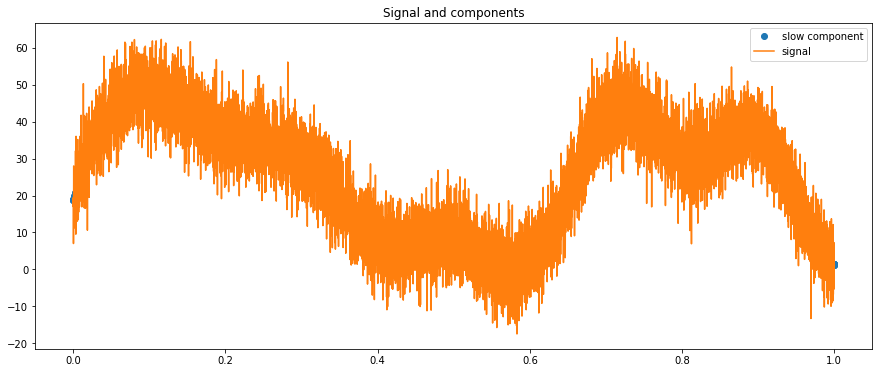

In [127]:
plt.plot(t[0:zoom_plot_size], slow_component[0:zoom_plot_size], 'o', 
         t[0:zoom_plot_size], signal[0:zoom_plot_size], '-')
plt.title("Signal and components")
plt.legend(['slow component', 'signal'], loc='best')
plt.show()

# Filtering with an exponential moving average

In [128]:
# Converting the numpy into a pandas series as it has ewma
pdslow = pd.Series(slow_component, t)
pdsignal = pd.Series(signal, t)
pdsignal_mean = pdsignal.ewm(halflife=35).mean()

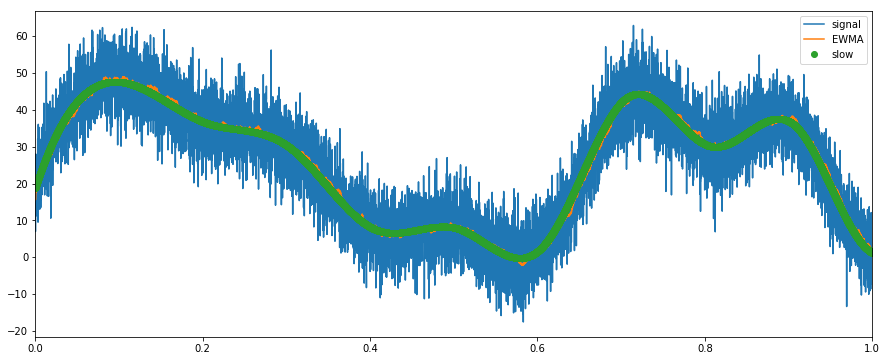

In [129]:
pdsignal.head(zoom_plot_size).plot()
pdsignal_mean.head(zoom_plot_size).plot()
pdslow.head(zoom_plot_size).plot(style='o')
plt.legend(['signal', 'EWMA', 'slow'])
plt.show()

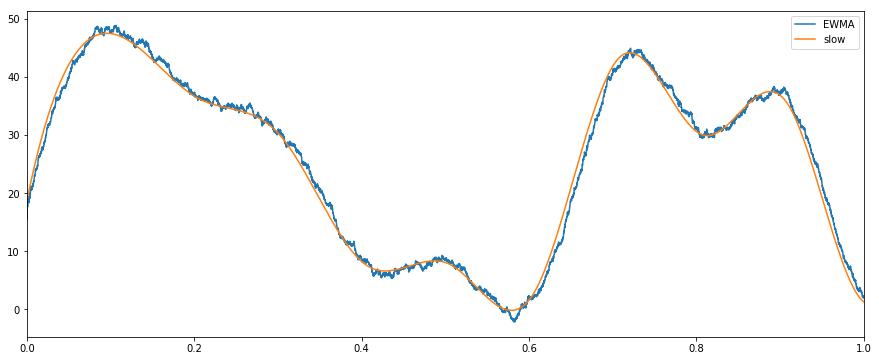

In [130]:

pdsignal_mean.head(zoom_plot_size).plot()
pdslow.head(zoom_plot_size).plot(style='-')
plt.legend(['EWMA', 'slow'])
plt.show()

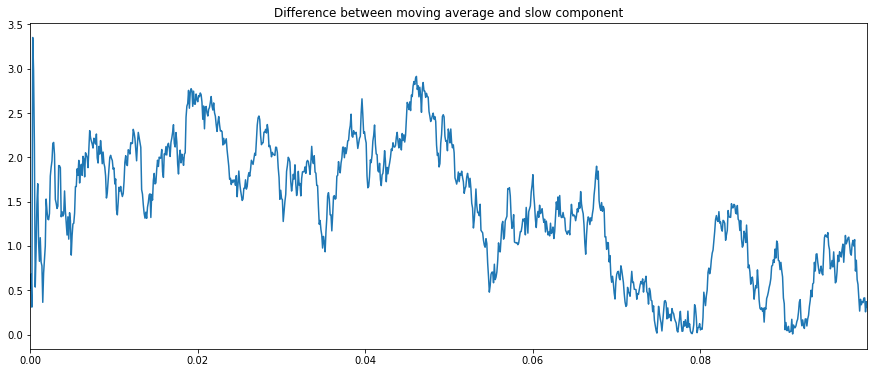

In [131]:
pddiff = abs(pdsignal_mean - pdslow)
pddiff.head(1000).plot()
plt.title("Difference between moving average and slow component")
plt.show()

## Trying a simple g-h filter

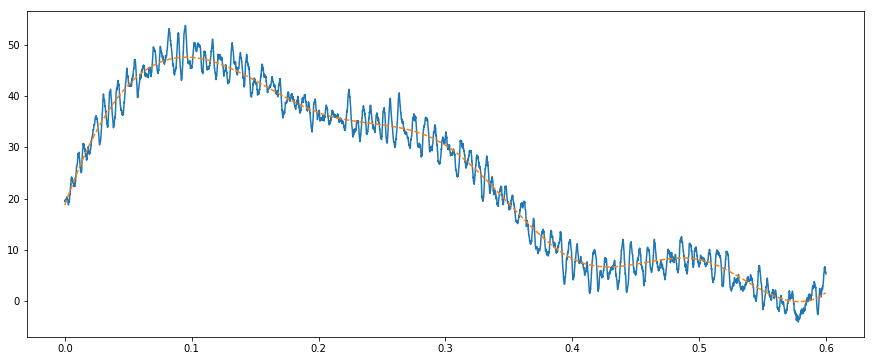

In [132]:

g = 0.04
h = 0.01
# That's not optimal but not worth investigating 

x = signal[0]
xp = 0.2
filtered = np.zeros(signal.shape)

for i, x_real in enumerate(signal):
    # predict
    x_pred = x + xp
        
    # Update model
    residual = x_real - x_pred
    xp = xp + h * residual
    x = x_pred + g * residual
    filtered[i] = x
    
myzoom=6000
plt.plot(t[0:myzoom], filtered[0:myzoom], '-')
plt.plot(t[0:myzoom], slow_component[0:myzoom], '--')

plt.show()


    

## Trying a Kalman filter

See https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf
Modelling with a hidden var

In [251]:
# Initial state
kfil = np.zeros(signal.shape)
X0 = np.array([[0.], [0.]]) # Initial state, dim2, position and speed...
P0 = np.array([[ 30., 0.], 
               [0., 35.]])
dt= t[1]-t[0]
A = np.array([[ 1, dt], 
              [0, 1]])
Q = np.array([[ 0.01, 0.01], 
              [ 0.01, 0.01]]) # Process error - todo: tune this!!
H = np.array([[1., 0.]]) # Measurement function, we only know the value
R = np.array([[20]]) # Measurement error
debug = False
for i, s in enumerate(signal):
    # Predicting the next state
    X1 = np.dot(A, X0)
    P1 = np.dot(np.dot(A, P0 ), A.T) + Q

    # Updating our state    
    S = np.dot(H, P1).dot(H.T) + R
    K = np.dot(P1, H.T).dot(inv(S)) # Kalman gain
    
    y = s - np.dot(H, X1) # Residual
    X0 = X1 + np.dot(K, y) # proper state update
    P0 = P1 - np.dot(K, H).dot(P1)
    kfil[i] = X0[0]
    
    if i < 10 and debug:
        print("======")
        print("signal:", s)
        print("Predicted:", X1)
        print("P1:", P1)
        print("Residual:", y)
        print("K:", K)
        print("S:", S)
        print("Final:", X0)


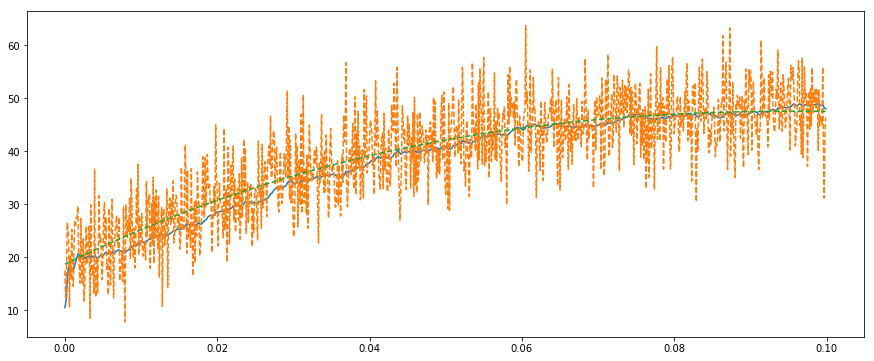

In [267]:
myzoom=1000
plt.plot(t[0:myzoom], kfil[0:myzoom], '-')
plt.plot(t[0:myzoom], signal[0:myzoom], '--')
plt.plot(t[0:myzoom], slow_component[0:myzoom], '--')

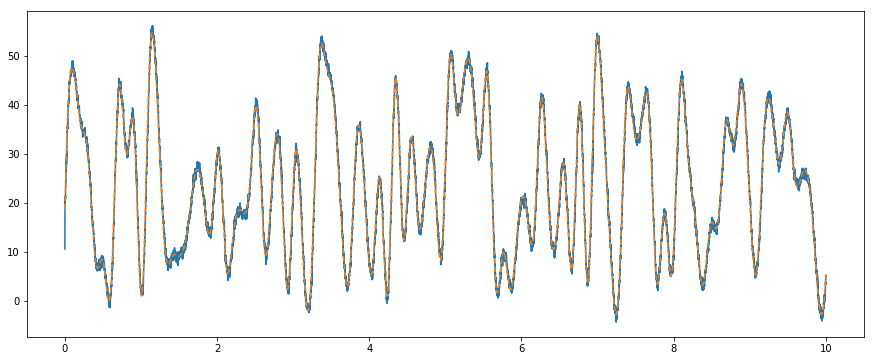

In [253]:
myzoom=len(signal)
plt.plot(t[0:myzoom], kfil[0:myzoom], '-')
#plt.plot(t[0:myzoom], signal[0:myzoom], '--')
plt.plot(t[0:myzoom], slow_component[0:myzoom], '--')
plt.show()

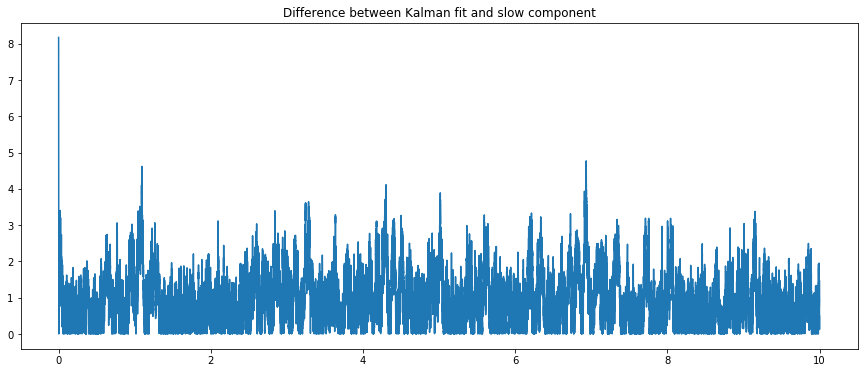

In [255]:
kdiff = abs(kfil - slow_component)
plt.plot(t[0:myzoom], kdiff[0:myzoom])
plt.title("Difference between Kalman fit and slow component")
plt.show()

## Kalman filter that expects a constant value 

c.f. https://scipy.github.io/old-wiki/pages/Cookbook/KalmanFiltering.html

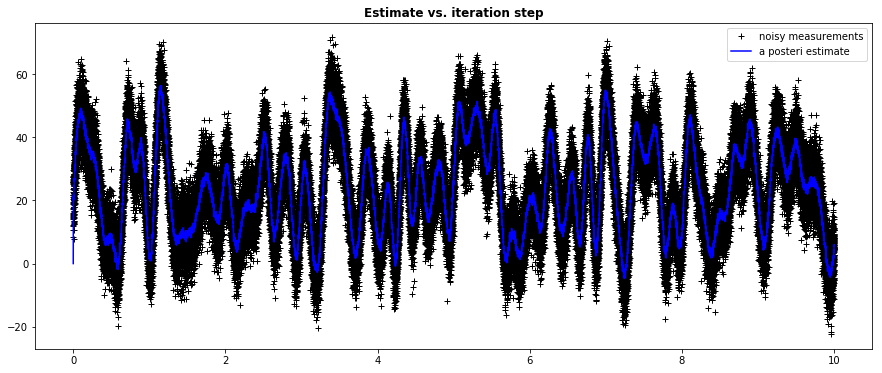

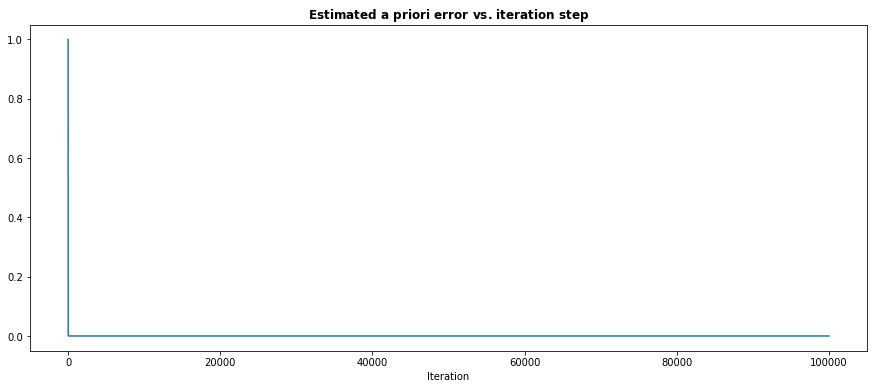

In [258]:
# intial parameters
n_iter = len(signal)
sz = (n_iter,) # size of array
z = signal

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]
    
plt.figure()
plt.plot(t, z,'k+',label='noisy measurements')
plt.plot(t, xhat,'b-',label='a posteri estimate')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')

plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.show()

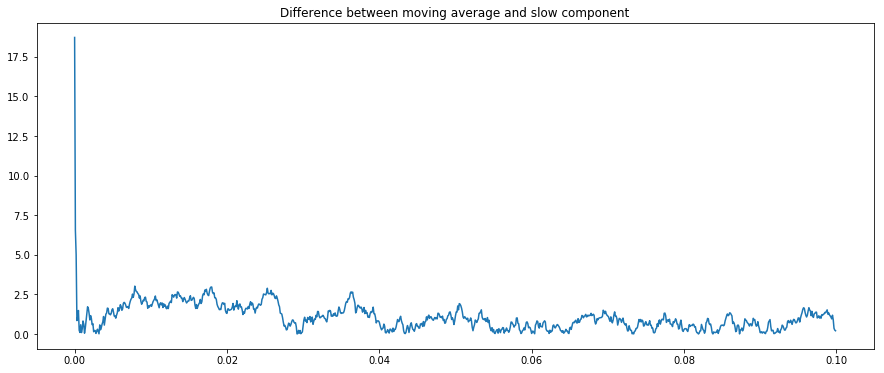

In [259]:
kdiff = abs(xhat - slow_component)
plt.plot(t[0:1000], kdiff[0:1000])
plt.title("Difference between moving average and slow component")
plt.show()

## Trying a Kalman filter (3)

See https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf

Modelling with a hidden vars

In [324]:
# Initial state
kfil = np.zeros(signal.shape)
X0 = np.array([[signal[0]], [0.], [0.]]) # Initial state, dim2, position and speed...
P0 = np.array([[ 35., 0., 0.], 
               [0., 35., 0.],
              [0., 0., 1]])
dt= t[1]-t[0]
A = np.array([[ 1, dt, 0.], 
              [0, 1, dt],
              [0., 0., 1.]])
Q = np.array([[ 0.05, 0.0, 0.0], 
              [ 0.0, 0.01, 0.0],
              [ 0.0, 0.0, 0.01]]) # Process error - todo: tune this!!
H = np.array([[1., 0., 0.]]) # Measurement function, we only know the value
R = np.array([[60]]) # Measurement error
debug = False
for i, s in enumerate(signal):
    # Predicting the next state
    X1 = np.dot(A, X0)
    P1 = np.dot(np.dot(A, P0 ), A.T) + Q

    # Updating our state    
    S = np.dot(H, P1).dot(H.T) + R
    K = np.dot(P1, H.T).dot(inv(S)) # Kalman gain
    
    y = s - np.dot(H, X1) # Residual
    X0 = X1 + np.dot(K, y) # proper state update
    P0 = P1 - np.dot(K, H).dot(P1)
    kfil[i] = X0[0]
    
    if i < 10 and debug:
        print("======")
        print("signal:", s)
        print("Predicted:", X1)
        print("P1:", P1)
        print("Residual:", y)
        print("K:", K)
        print("S:", S)
        print("Final:", X0)


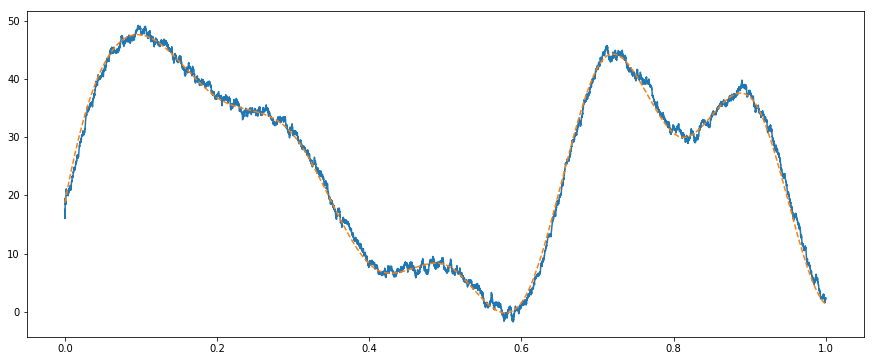

In [325]:
myzoom=10000
plt.plot(t[0:myzoom], kfil[0:myzoom], '-')
#plt.plot(t[0:myzoom], signal[0:myzoom], '--')
plt.plot(t[0:myzoom], slow_component[0:myzoom], '--')

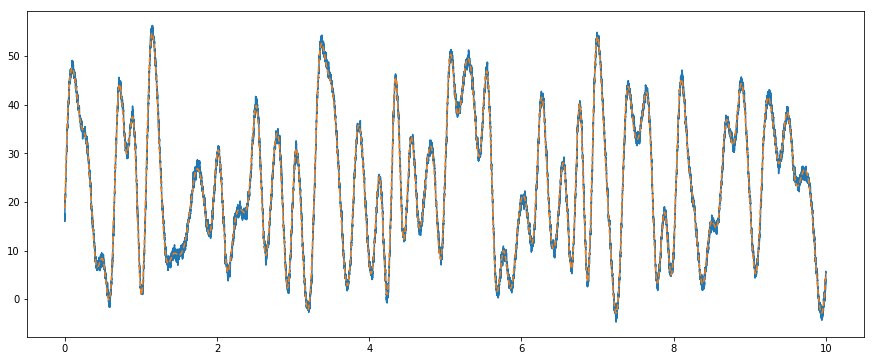

In [326]:
myzoom=len(signal)
plt.plot(t[0:myzoom], kfil[0:myzoom], '-')
#plt.plot(t[0:myzoom], signal[0:myzoom], '--')
plt.plot(t[0:myzoom], slow_component[0:myzoom], '--')
plt.show()

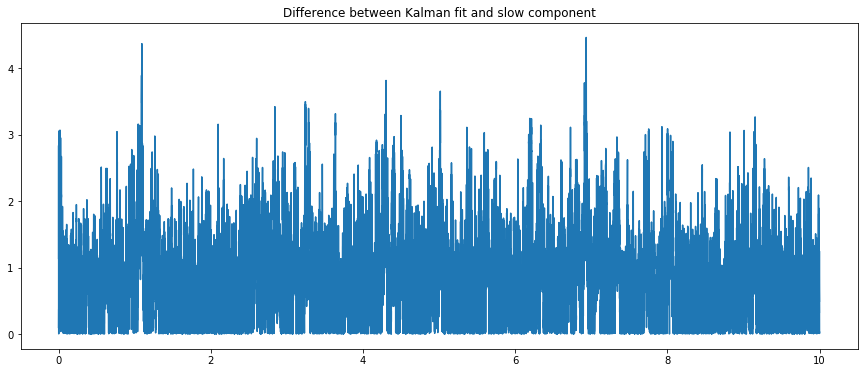

In [327]:
kdiff = abs(kfil - slow_component)
plt.plot(t[0:myzoom], kdiff[0:myzoom])
plt.title("Difference between Kalman fit and slow component")
plt.show()

## Fourier approach

Not appropriate as we have random signals, but just to try out the tools :-)

In [260]:
from scipy.fftpack import rfft, irfft, fftfreq

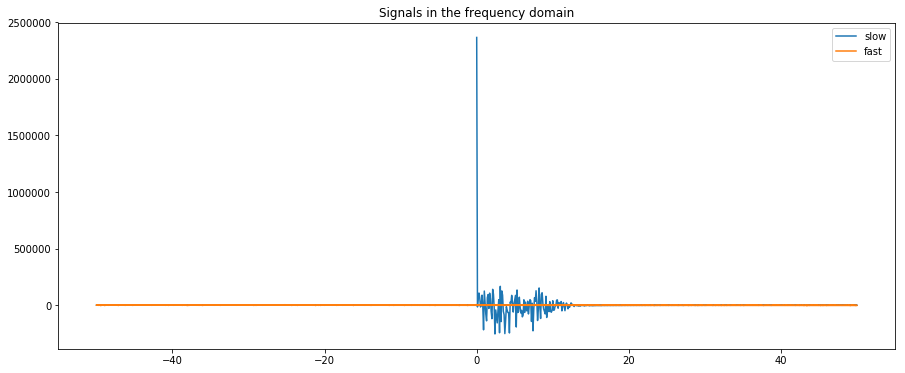

In [261]:

W = fftfreq(slow_component.size, d=t[1]-t[0])
f_slow_component = rfft(slow_component)
f_fast_component = rfft(fast_component)
f_signal = rfft(signal)
plt.plot(W[abs(W)<50], f_slow_component[abs(W)<50])
plt.plot(W[abs(W)<50], f_fast_component[abs(W)<50])
plt.legend(["slow", "fast"])
plt.title("Signals in the frequency domain")
plt.show()



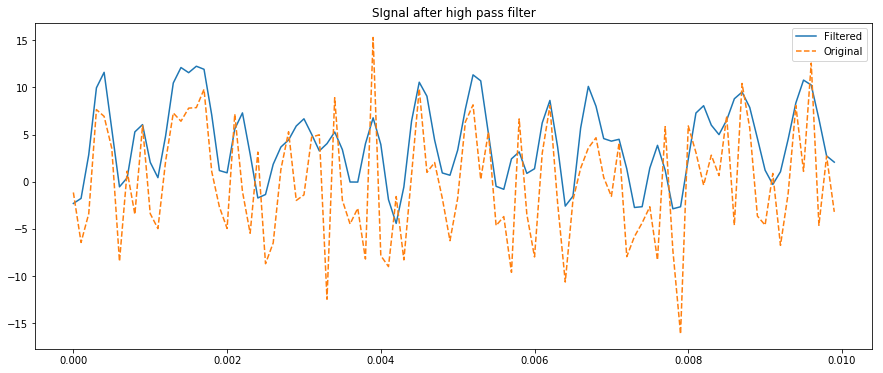

In [262]:
cut_f_signal = f_signal.copy()
cut_f_signal[(W<15)] = 0
cut_signal = irfft(cut_f_signal)
myzoom=100
plt.plot(t[0:myzoom], cut_signal[0:myzoom], '-')
plt.plot(t[0:myzoom], fast_component[0:myzoom], '--')
plt.title("SIgnal after high pass filter")
plt.legend(["Filtered", "Original"])
plt.show()


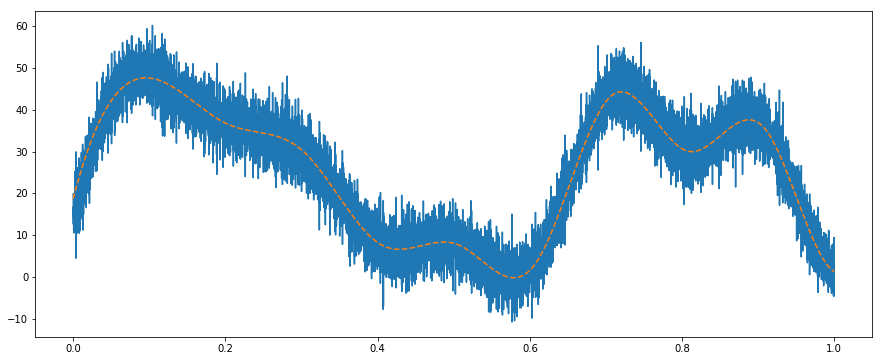

In [263]:
highcut_f_signal = f_signal.copy()
highcut_f_signal[(W>15)] = 0
highcut_signal = irfft(highcut_f_signal)
myzoom=10000
plt.plot(t[0:myzoom], highcut_signal[0:myzoom], '-')
plt.plot(t[0:myzoom], slow_component[0:myzoom], '--')

plt.show()


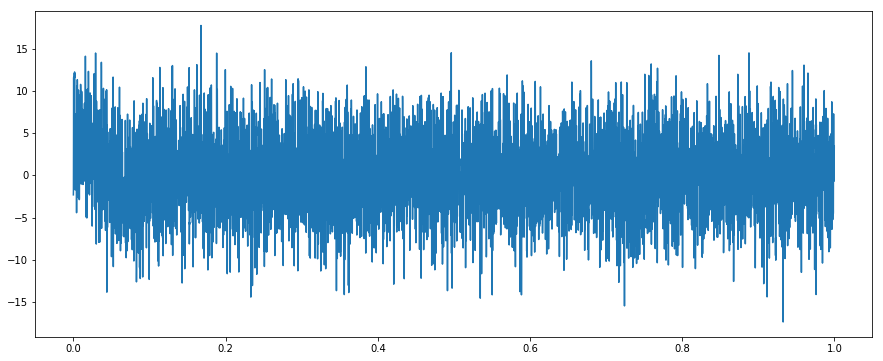

In [264]:
res = signal - highcut_signal
myzoom=10000
plt.plot(t[0:myzoom], res[0:myzoom], '-')
plt.show()
